In [1]:
import torch.nn as nn
from torch.nn import Module
import torch
import torch.nn.functional as F
import torch.distributions as D
from livelossplot import PlotLosses

from typing import Iterable, Optional
import math
import csv
import copy
from dataclasses import dataclass
import numpy as np
from collections import defaultdict
import tqdm

from reflect.data.differentiable_pendulum import DiffPendulumEnv
from reflect.models.rl.value_trainer import ValueGradTrainer, update_target_network
from reflect.models.rl.actor import Actor
from reflect.models.rl.value_critic import ValueCritic

In [2]:
actor = Actor(
    input_dim=3,
    output_dim=1,
    hidden_dim=64,
    num_layers=3,
    bound=2
)

critic = ValueCritic(
    state_dim=3,
    hidden_dim=64,
    num_layers=3
)

trainer = ValueGradTrainer(
    actor=actor,
    critic=critic,
    actor_lr=0.0005,
    critic_lr=0.0001,
    env=None
)

plotlosses = PlotLosses(
  groups={
    'return': ['return'],
    'last_reward': ['last_reward'],
    'policy_loss': ['policy_loss'],
    'critic_loss': ['critic_loss'],
    'entropy': ['entropy']
  },
)


batch_size = 32
env = DiffPendulumEnv()
env.set_seed(0)
logs = defaultdict(list)

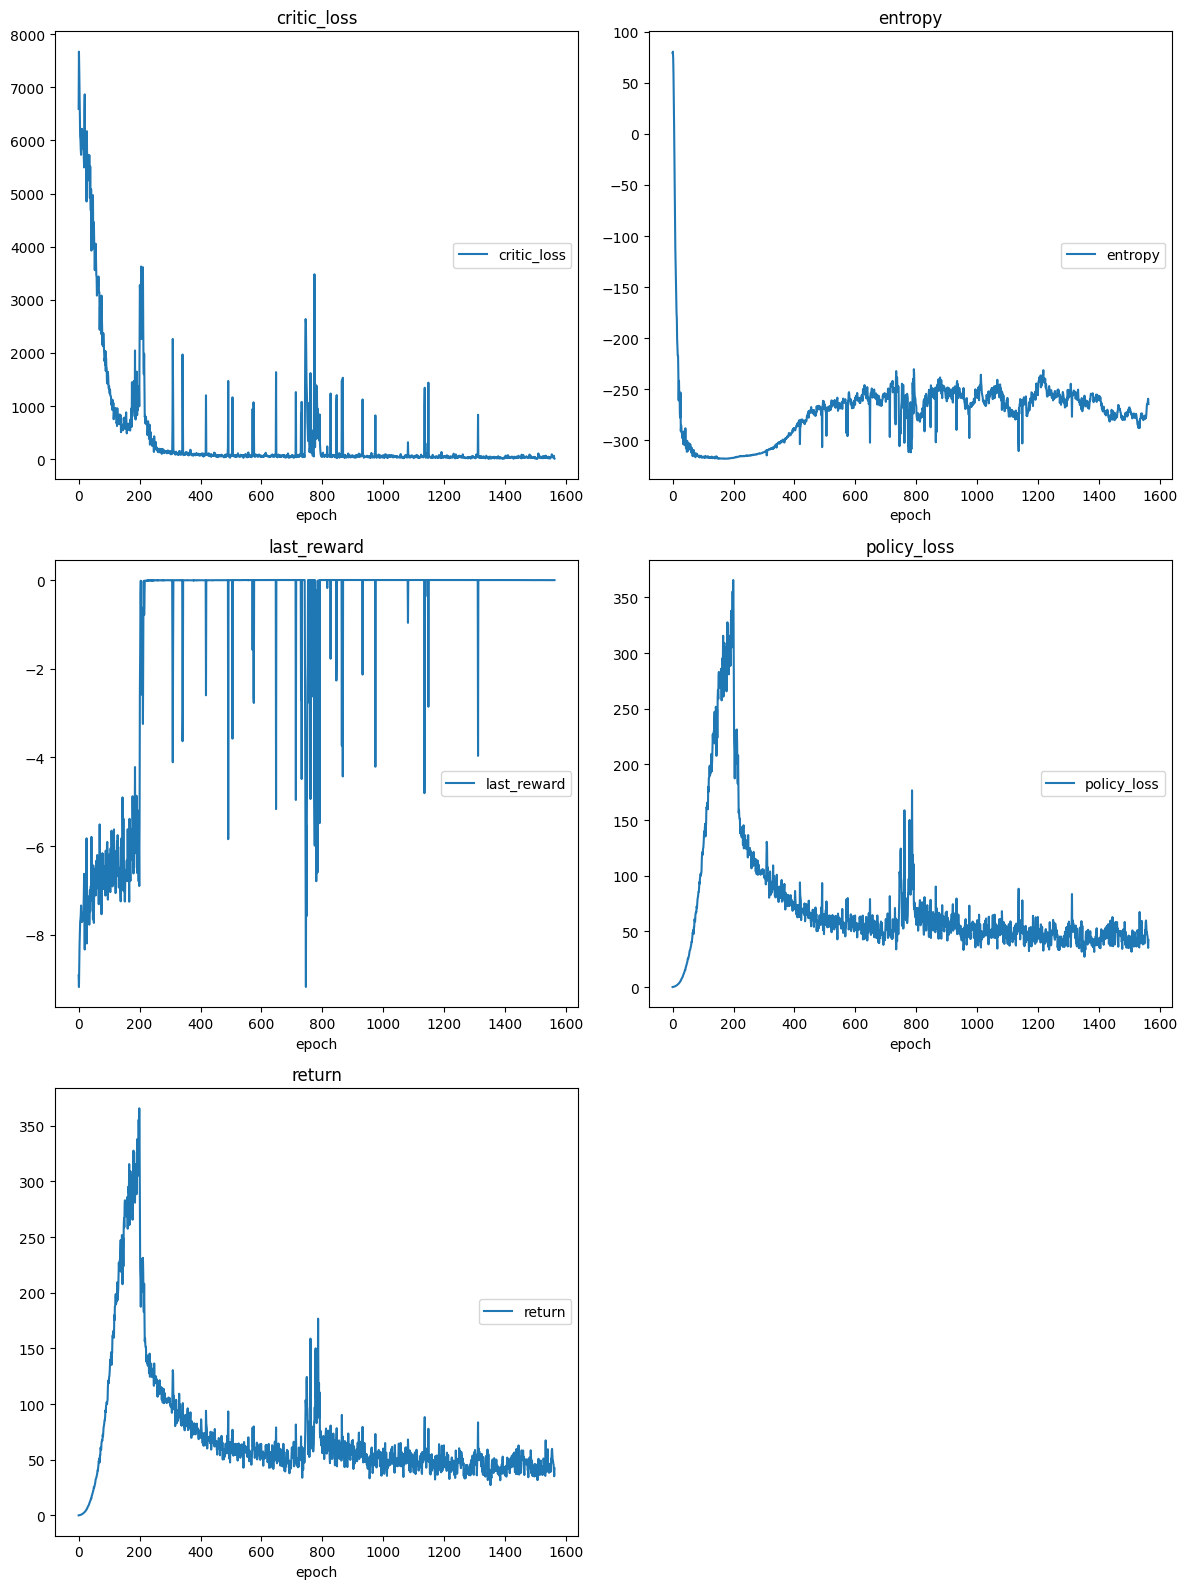

critic_loss
	critic_loss      	 (min:    8.359, max: 7669.710, cur:    9.847)
entropy
	entropy          	 (min: -318.068, max:   80.543, cur: -264.574)
last_reward
	last_reward      	 (min:   -9.175, max:   -0.000, cur:   -0.002)
policy_loss
	policy_loss      	 (min:    0.087, max:  365.571, cur:   42.379)
return
	return           	 (min:    0.095, max:  365.540, cur:   42.352)


In [3]:
for iteration in range(500_000 // batch_size):
    current_state, _ = env.reset(batch_size=batch_size)
    rewards = []
    dones = []
    states = []
    entropy = 0
    for _ in range(100):
        action_dist = trainer.actor(current_state)
        action = action_dist.rsample()
        action = action.squeeze(1)
        states.append(current_state)
        next_state, reward, done, _ = env.step(action)
        entropy = entropy + action_dist.entropy().mean()
        current_state = next_state
        rewards.append(reward)
        dones.append(done)

    rewards = torch.stack(rewards, dim=1)
    states = torch.stack(states, dim=1)
    dones = torch.stack(dones, dim=1).to(torch.float32)

    actor_loss = trainer.policy_loss(state_samples=states)
    policy_loss = actor_loss - trainer.entropy_weight * entropy
    trainer.actor_optim.backward(actor_loss)
    trainer.actor_optim.update_parameters()

    critic_loss = trainer.critic_loss(
        states.detach(),
        rewards.detach(),
        dones.detach()
    )
    trainer.critic_optim.backward(critic_loss)
    trainer.critic_optim.update_parameters()
    update_target_network(trainer.target_critic, trainer.critic)

    if iteration % 10 == 0:
        logs["return"].append(actor_loss.detach().item())
        logs["last_reward"].append(rewards[:, -1].detach().mean().item())
        logs["policy_loss"].append(policy_loss.detach().mean().item())
        logs["critic_loss"].append(critic_loss.detach().mean().item())
        logs["entropy"].append(entropy.detach().item())

        data = {
            'return': logs['return'][-1],
            'last_reward': logs['last_reward'][-1],
            'policy_loss': logs['policy_loss'][-1],
            'critic_loss': logs['critic_loss'][-1],
            'entropy': logs['entropy'][-1]
        }

        plotlosses.update(data)
        plotlosses.send()

